<a href="https://colab.research.google.com/github/PeterCalifano/MathFoundationsForML_courseCodes/blob/main/SciML_Burgers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of PINN solution of the Viscous Burgers PDE

ECEN 689 Scientific Machine Learning - Spring 2023

Tensorflow 2.x barebones implementation of<br>
PINN solution of Burgers PDE with sinusoidal IC<br>

Author: Ulisses Braga-Neto <br>
Department of Electrical and Computer Engineering<br>
Texas A&M University<br>

This code demonstrates coding and training a physically-informed neural networks (PINN) to solve  the viscous Burgers nonlinear PDE with a sinusoidal initial condition and homogeneous Dirichlet boundary conditions:

  \begin{aligned}
  &u_t + uu_x = \nu u_{xx}\,, \quad (x,t) \in [-1,1] \times [0,\infty)\,,\\
    & u(x,0) = -\sin(\pi x)\,, \quad -1 < x < 1\,, \\
    &u(1,t) = u(-1,t) = 0\,, \quad t>0\,,\\
  \end{aligned}

where $\nu>0$ is the kinematic viscosity. If $\nu =0$, this is the inviscid Burgers equation. If $\nu$ is smaller than about $0.1\pi$, the solution of (1) has a hyperbolic character, and a "shock" forms at $x=0$.

The PINN solution is compared to an accurate Gauss-Hermite quadrature of the Cole-Hopf formula for the exact solution.
The quadrature approximation is based on the fact that, for small enough $\nu$, (1) is an approximation of the inviscid Burgers problem, in which case it can be proved using the method of characteristics that any zero value in the initial condition stays constant at zero throughout the solution. Therefore, (1) is approximately equal to the initial-value problem (IVP):
\begin{aligned}
  &\hat{u}_t + \hat{u}\hat{u}_x = \nu \hat{u}_{xx}\,, \quad (x,t) \in R \times [0,\infty)\,,\\
    & \hat{u}(x,0) = \begin{cases} -\sin(\pi x)\,,& -1 < x < 1\,,\\
    0\,, & |x|>1\,. \end{cases} \quad\quad\quad\quad  (2)\\
  \end{aligned}
The Cole-Hopf transform [1] provides a closed-form solution to the IVP (2):

$$\hat{u}(x,t) = -\frac{\int_{-\infty}^\infty \sin(\pi(x-z))\exp\left(-\frac{\cos(\pi(x-z))}{2\pi \nu}\right)\exp\left(-\frac{z^2}{4\nu t}\right)\, dz}
{\int_{-\infty}^\infty \exp\left(-\frac{\cos(\pi(x-z))}{2\pi \nu}\right)\exp\left(-\frac{z^2}{4\nu t}\right)\, dz}\,.$$

For sufficiently small $t$, we have $u(x,t) \approx \hat{u}(x,t)$, for $x \in [-1,1]$. In [2], it is claimed that Gauss-Hermite quadrature produced a seven-digit accurate result for $u_x(0,t)$ up to $t = 3/\pi$ with a viscosity $\nu = 0.01/\pi$.

References:

[1]  E. Hopf, The partial differential equation $u_t + uu_x = \mu u_{xx}$. Comm. Pure Appl. Math. 3, 201-230, 1950.

[2] Claude Basdevant, Michel Deville, Pierre Haldenwang, J Lacroix,
  J Ouazzani, Roger Peyret, Paolo Orlandi, Anthony Patera,
  Spectral and finite difference solutions of the Burgers equation,
  Computers and Fluids,   Volume 14, Number 1, 1986, pages 23-41.

In [ ]:
# import necessary libraries

import tensorflow as tf
import numpy as np
import scipy.io
import math
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
!pip -q install pyDOE
from pyDOE import lhs  # for latin hypercube sampling


In [ ]:
"""
Problem Definition and Quadrature Solution
"""

import numpy as np
from numpy.polynomial.hermite import hermgauss

nu = 0.01/np.pi # viscosity parameter

# define grid for quadrature solution
utn = 128
uxn = 256
xlo = -1.0
xhi = +1.0
ux = np.linspace(xlo,xhi,uxn)
tlo = 0.0
thi = 5.0/np.pi
ut = np.linspace (tlo,thi,utn)

qn = 64 # order of quadrature rule
qx,qw = hermgauss(qn)

# compute solution u(x,t) by quadrature of analytical formula:
u_quad = np.zeros([uxn,utn])
for utj in range(utn):
  if (ut[utj]==0.0):
    for uxj in range(uxn):
      u_quad[uxj,utj] = -np.sin(np.pi*ux[uxj])
  else:
    for uxj in range(uxn):
      top = 0.0
      bot = 0.0
      for qj in range(qn):
        c = 2.0*np.sqrt(nu*ut[utj])
        top = top-qw[qj]*c*np.sin(np.pi*(ux[uxj]-c*qx[qj]))*np.exp(-np.cos(np.pi*(ux[uxj]-c*qx[qj]))/(2.0*np.pi*nu))
        bot = bot+qw[qj]*c*np.exp(-np.cos(np.pi*(ux[uxj]-c*qx[qj]))/(2.0*np.pi*nu))
        u_quad[uxj,utj] = top/bot

# flatten grid and solution
X,T = np.meshgrid(ux,ut)
X_flat = tf.convert_to_tensor(np.hstack((X.flatten()[:,None],T.flatten()[:,None])),dtype=tf.float32)
u_flat = u_quad.T.flatten()

In [ ]:

# PINN loss function
def loss(xcl,tcl,x0,t0,u0,xlb,tlb,ulb,xub,tub,uub):
    u0_pred  = u_PINN(tf.concat([x0,t0],1))
    ulb_pred = u_PINN(tf.concat([xlb,tlb],1))
    uub_pred = u_PINN(tf.concat([xub,tub],1))
    r_pred   = r_PINN(xcl,tcl)

    # loss components
    mse_0  = tf.reduce_mean(tf.pow(u0-u0_pred,2))
    mse_lb = tf.reduce_mean(tf.pow(ulb_pred-ulb,2))
    mse_ub = tf.reduce_mean(tf.pow(uub_pred-uub,2))
    mse_r  = tf.reduce_mean(tf.pow(r_pred,2))

    return  mse_0+mse_r+mse_lb+mse_ub

# neural network weight gradients
@tf.function
def grad(model,xcl,tcl,x0,t0,u0,xlb,tlb,ulb,xub,tub,uub):
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(xcl,tcl,x0,t0,u0,xlb,tlb,ulb,xub,tub,uub)
        grads = tape.gradient(loss_value,model.trainable_variables)
    return loss_value, grads

In [ ]:
# collocation points
Ncl = 10000
X = lhs(2,Ncl)
xcl = tf.expand_dims(tf.convert_to_tensor(xlo+(xhi-xlo)*X[:,0],dtype=tf.float32),-1)
tcl = tf.expand_dims(tf.convert_to_tensor(tlo+(thi-tlo)*X[:,1],dtype=tf.float32),-1)

# initial condition points
N0 = 500
X = lhs(1,N0)
x0 = tf.expand_dims(tf.convert_to_tensor(xlo+(xhi-xlo)*X[:,0],dtype=tf.float32),-1)
t0 = tf.zeros(tf.shape(x0),dtype=tf.float32)
u0 = -tf.math.sin(np.pi*x0)

# Dirichlet boundary condition points
Nb = 500
X = lhs(1,Nb)
tlb = tf.expand_dims(tf.convert_to_tensor(tlo+(thi-tlo)*X[:,0],dtype=tf.float32),-1)
xlb = xlo*tf.ones(tf.shape(tlb),dtype=tf.float32)
ulb = tf.zeros(tf.shape(tlb),dtype=tf.float32)
X = lhs(1,Nb)
tub = tf.expand_dims(tf.convert_to_tensor(tlo+(thi-tlo)*X[:,0],dtype=tf.float32),-1)
xub = xlo*tf.ones(tf.shape(tub),dtype=tf.float32)
uub = tf.zeros(tf.shape(tub),dtype=tf.float32)

iter =  200
loss = 0.1234
L2 error: 5.7059e-01


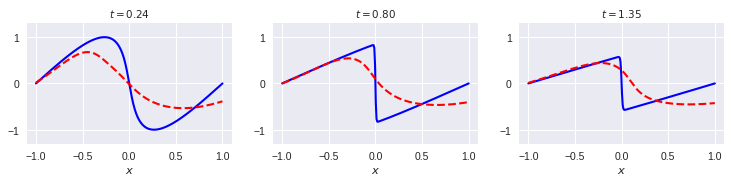

iter =  400
loss = 0.0448
L2 error: 2.4695e-01


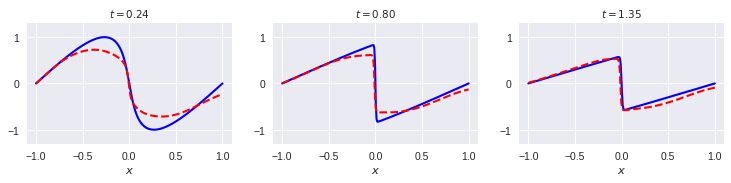

iter =  600
loss = 0.0122
L2 error: 1.4480e-01


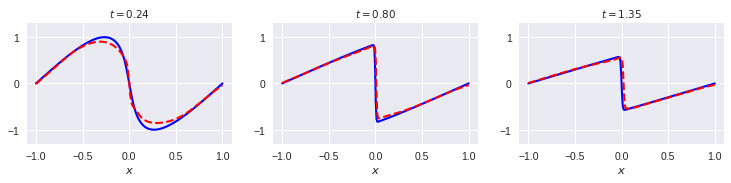

iter =  800
loss = 0.0047
L2 error: 1.0516e-01


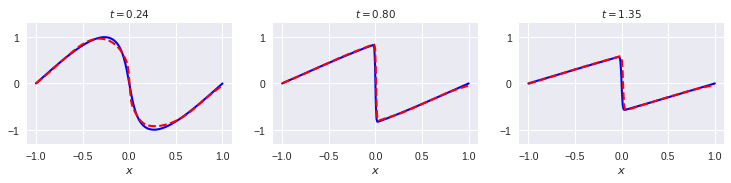

iter =  1000
loss = 0.0023
L2 error: 8.4850e-02


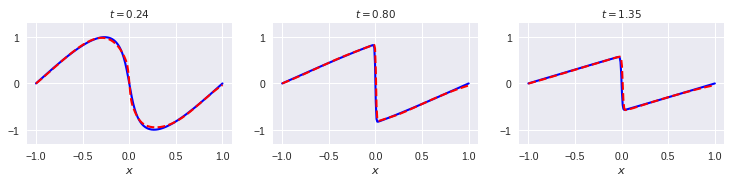

iter =  1200
loss = 0.0012
L2 error: 4.3941e-02


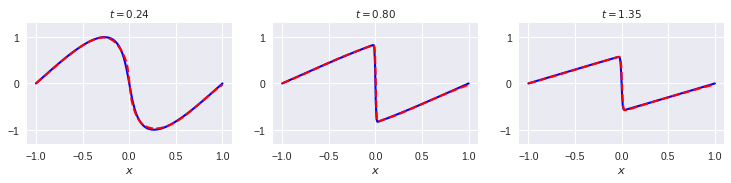

iter =  1400
loss = 0.0008
L2 error: 4.7675e-02


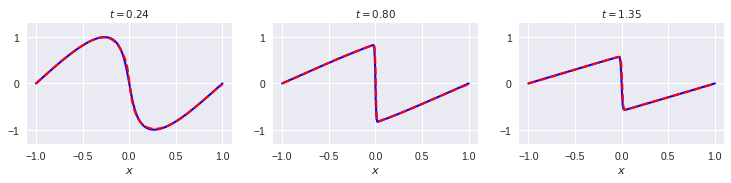

iter =  1600
loss = 0.0007
L2 error: 4.5094e-02


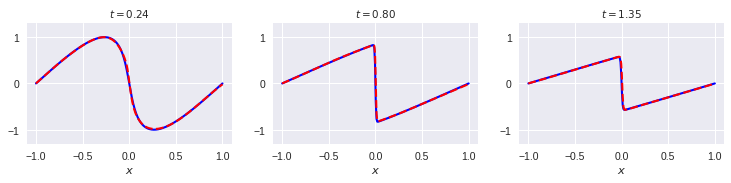

iter =  1800
loss = 0.0005
L2 error: 4.3561e-02


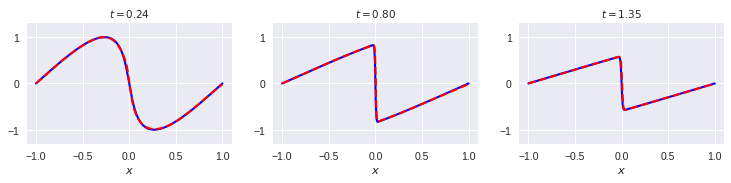

iter =  2000
loss = 0.0005
L2 error: 4.1730e-02


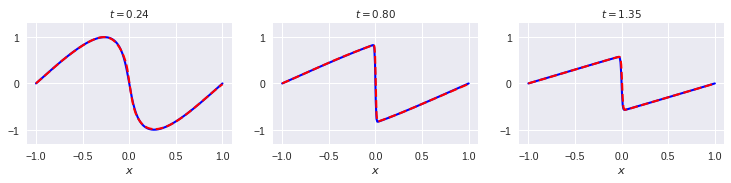

In [ ]:
# training loop

# initialize new instance of NN
layer_sizes = [2] + 8*[20] + [1]
u_PINN = neural_net(layer_sizes)

# residual neural network
@tf.function
def r_PINN(x,t):
    u    = u_PINN(tf.concat([x,t], 1))
    u_x  = tf.gradients(u,x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_t  = tf.gradients(u,t)[0]
    return u_t + u*u_x - nu*u_xx

# Adam optimizer
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.003,beta_1=0.99)

for iter in range(2000):

  # compute gradients using AD
  loss_value,grads = grad(u_PINN,xcl,tcl,x0,t0,u0,xlb,tlb,ulb,xub,tub,uub)

  # update neural network weights
  tf_optimizer.apply_gradients(zip(grads,u_PINN.trainable_variables))

  # display intermediate results
  if ((iter+1) % 200 == 0):
    print('iter =  '+str(iter+1))
    print('loss = {:.4f}'.format(loss_value))
    u_PINN_flat = u_PINN(X_flat)
    err = np.linalg.norm(u_flat-u_PINN_flat[:,-1],2)/np.linalg.norm(u_flat,2)
    print('L2 error: %.4e' % (err))
    #plot_slices(u_flat,u_PINN_flat,[0.15,0.5,0.85])
    fig = plt.figure(figsize=(12,4),dpi=75)
    plt.style.use('seaborn')
    for gi,snap in enumerate([0.15,0.5,0.85]):
      tind = int(snap*len(ut))
      ax = fig.add_subplot(1,3,gi+1)
      ax.set_aspect(0.5)
      ax.plot(ux,u_flat[tind*uxn:(tind+1)*uxn],'b-',linewidth=2,label='Exact')
      ax.plot(ux,u_PINN_flat[tind*uxn:(tind+1)*uxn,0],'r--',linewidth=2,label='Prediction')
      ax.set_title('$t = %.2f$' % (ut[tind]),fontsize=10)
      ax.set_xlabel('$x$')
      ax.set_ylim([-1.3,1.3])
    plt.show()

Text(0.5, 1.0, 'PINN Prediction (L2 error = 0.0417)')

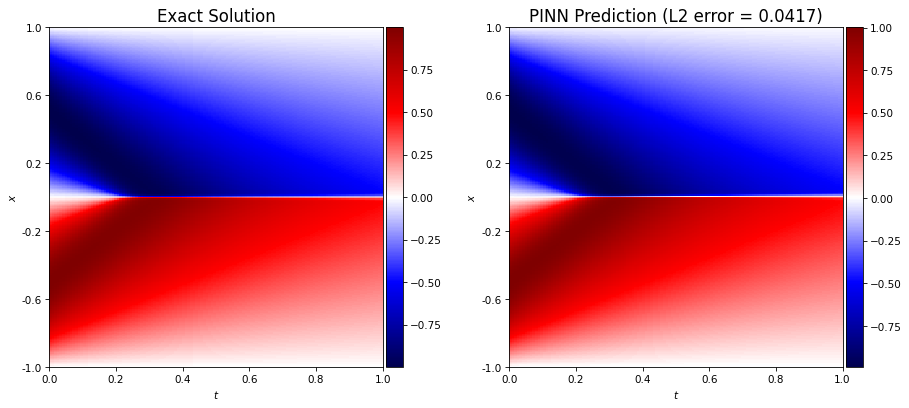

In [ ]:
#Display results

fig = plt.figure(figsize=(14,6),dpi=75)
fig.subplots_adjust(wspace=0.3)
plt.style.use('default')
ax = fig.add_subplot(121)
ax.set_aspect(1)
im=ax.imshow(np.reshape(u_flat,(utn,uxn)).T,interpolation='nearest',cmap='seismic',extent=[0.0,1.0,0.0,1.0],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_yticklabels(['-1.0','-0.6','-0.2','0.2','0.6','1.0'])
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Exact Solution',fontsize=16)

ax = fig.add_subplot(122)
ax.set_aspect(1)
im=ax.imshow(np.reshape(u_PINN_flat,(utn,uxn)).T,interpolation='nearest',cmap='seismic',extent=[0.0,1.0,0.0,1.0],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_yticklabels(['-1.0','-0.6','-0.2','0.2','0.6','1.0'])
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('PINN Prediction (L2 error = {:.4f})'.format(err),fontsize=16)